In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import scipy.io
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
print("Package loaded.")

Package loaded.


<h1>LOAD DATA</h1>

In [2]:
cwd = os.getcwd()
loadpath = cwd+"/data/data4vgg.npz"
l = np.load(loadpath)

#show files
print(l.files)

['trainlabel', 'trainimg', 'testimg', 'testlabel']


<h1>Parse Data</h1>

In [3]:
trainimg = l['trainimg']
trainlabel = l['trainlabel']
testimg = l['testimg']
testlabel = l['testlabel']

ntrain = trainimg.shape[0]
nclass= trainlabel.shape[1]
dim = trainimg.shape[1]

ntest = testimg.shape[0]

print("%d train images loaded" %(ntrain))
print("%d test images loaded"%(ntest))
print("%d dimensional input" %(dim))
print("%d classes" %(nclass))
print("shape of 'trainimg' is %s" %(trainimg.shape,))
print("shape of 'testimg' is %s"%(testimg.shape,))

69 train images loaded
18 test images loaded
37632 dimensional input
2 classes
shape of 'trainimg' is (69, 37632)
shape of 'testimg' is (18, 37632)


<h1> GENERATE TENSORS FOR TRAINING AND TESTING </h1>

In [4]:
trainimg_tensor = np.ndarray( (ntrain,112,112,3) )

for i in range(ntrain):
    currimg = trainimg[i,:]
    currimg = np.reshape(currimg, [112,112,3] )
    trainimg_tensor[i,:,:,:] = currimg
print("shape of trainimg_tensor is %s"%(trainimg_tensor.shape,))


testimg_tensor = np.ndarray((ntest, 112,112,3))
for i in range(ntest):
    currimg = testimg[i,:]
    currimg = np.reshape(currimg,[112,112,3]) 
    testimg_tensor[i,:,:,:] = currimg
print("shape of testimg_tensor is %s"%(testimg_tensor.shape,))

shape of trainimg_tensor is (69, 112, 112, 3)
shape of testimg_tensor is (18, 112, 112, 3)


<h1>DEFINE A FUNCTION FOR USING PRETRAINED VGG NETWORK</h1>

In [5]:
def net(data_path, input_image):
    layers=(
        'conv1_1','relu1_1','conv1_2','relu1_2','pool1',
        'conv2_1','relu2_1','conv2_2','relu2_2','pool2',
        'conv3_1','relu3_1','conv3_2','relu3_2','conv3_3',
        'relu3_3','conv3_4','relu3_4','pool3',
        'conv4_1','relu4_1','conv4_2','relu4_2','conv4_3',
        'relu4_3','conv4_4','relu4_4','pool4',
        'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3',
        'relu5_3','conv5_4','relu5_4'
    
    )
    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean,axis=(0,1))
    weights = data['layers'][0]
    net = {}
    current = input_image
    
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            
            #matconvnet : weights are [width, height, in_channels, out_channels]
            #tensorflow : weights are [height,width, in_channels, out_channels]
            
            kernels = np.transpose(kernels,(1,0,2,3))
            bias = bias.reshape(-1)
            current = _conv_layer(current,kernels, bias)
        elif kind =='relu':
            current = tf.nn.relu(current)
        elif kind =='pool':
            current = _pool_layer(current)
        net[name] = current
        
    assert len(net) == len(layers)
    return net, mean_pixel


def _conv_layer(input,weights,bias):
    conv = tf.nn.conv2d(input,tf.constant(weights), strides=(1,1,1,1), padding='SAME')
    return tf.nn.bias_add(conv,bias)

def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')

def preprocess(image, mean_pixel):
    return image-mean_pixel

def unprocess(image,mean_pixel):
    return image+mean_pixel



<h1> EXTRACT FEATURES FROM THE VGG NETWORK </h1>

In [7]:
VGG_PATH = cwd+'/data/imagenet-vgg-verydeep-19.mat'

with tf.Graph().as_default(),  tf.Session() as sess:
    with tf.device('/gpu:0'):
        img_placeholder = tf.placeholder(tf.float32, shape=(None,112,112,3))
        net_val, mean_pixel = net(VGG_PATH, img_placeholder)
        
        train_features = net_val['relu5_4'].eval(feed_dict={img_placeholder: trainimg_tensor})
        test_features = net_val['relu5_4'].eval(feed_dict={img_placeholder: testimg_tensor})
        
print("TYPE OF 'train_features' IS %s " %(type(train_features)))
print("SHAPE OF 'train_features' IS %s" % (train_features.shape,))
print("TYPE OF 'test_features' IS %s "%(type(test_features)))
print("SHAPE OF 'test_features' IS %s"%(test_features.shape,))
print("PREPROCESSING DONE")

TYPE OF 'train_features' IS <class 'numpy.ndarray'> 
SHAPE OF 'train_features' IS (69, 7, 7, 512)
TYPE OF 'test_features' IS <class 'numpy.ndarray'> 
SHAPE OF 'test_features' IS (18, 7, 7, 512)
PREPROCESSING DONE


<h1>VECTORIZE CNN FEATURES</h1>

SHAPE OF 'train_vectorized' IS (69, 25088)
SHAPE OF 'test_vectorized' IS (18, 25088)


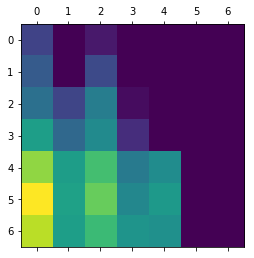

In [14]:
#VGG 끝 레이어를 통과한것
train_vectorized = np.ndarray((ntrain, 7*7*512))
test_vectorized = np.ndarray((ntest, 7*7*512))

for i in range(ntrain):
    curr_feat = train_features[i,:,:,:]
    curr_feat_vec = np.reshape(curr_feat,(1,-1))
    train_vectorized[i,:] = curr_feat_vec
    
for i in range(ntest):
    curr_feat = test_features[i,:,:,:]
    curr_feat_vec = np.reshape(curr_feat,(1,-1))
    test_vectorized[i, :] = curr_feat_vec
    
print("SHAPE OF 'train_vectorized' IS %s" %(train_vectorized.shape,))
print("SHAPE OF 'test_vectorized' IS %s" %(test_vectorized.shape,))


#TrainingImage가 relu5_3까지 전부 통과했을때의 모습

currimg = np.reshape(train_vectorized[0], [7,7,512] )

plt.matshow(currimg[:,:,0])
plt.show()

<h1> DEFINE NETWORKS AND FUNCTIONS(ADD 2LAYER MLP)</h1>

In [17]:
#Parameters
learning_rate = 0.0001
training_epochs = 100
batch_size = 100
display_step = 10

#Network
with tf.device("/gpu:0"):
    n_input = dim
    n_output = nclass
    
    weights ={
        'wd1': tf.Variable(tf.random_normal([7*7*512,1024], stddev=0.1)),
        'wd2': tf.Variable(tf.random_normal([1024, n_output], stddev=0.1))
    }
    
    biases = {
        'bd1': tf.Variable(tf.random_normal([1024], stddev=0.1)),
        'bd2': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    
    def conv_basic(_input, _w, _b, _keepratio):
        #input
        _input_r = _input
        
        #vectorize
        _dense1 = tf.reshape(_input_r, [-1,_w['wd1'].get_shape().as_list()[0]])
        
        #Fc1
        _fc1 = tf.nn.relu(tf.add(tf.matmul(_dense1, _w['wd1']), _b['bd1']))
        _fc_dr1 = tf.nn.dropout(_fc1,_keepratio)
        #Fc2
        _out = tf.add(tf.matmul(_fc_dr1, _w['wd2']), _b['bd2'])
        
        #Return everything
        out = {'input_r': _input_r, 'dense1':_dense1, 'fc1':_fc1, 'fc_dr1': _fc_dr1, 'out':_out}
        
        return out
    
#tf graph input
x = tf.placeholder(tf.float32, [None, 7*7*512])
y = tf.placeholder(tf.float32, [None, n_output])
keepratio = tf.placeholder(tf.float32)


#Functions!!
with tf.device("/gpu:0"):
    _pred = conv_basic(x, weights, biases, keepratio)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred,labels=y))
    optm = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    _corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1))
    accr = tf.reduce_mean(tf.cast(_corr, tf.float32))
    init = tf.global_variables_initializer()
    
print("Network Ready to go!!")

        

Network Ready to go!!


<h1> CNN Finetuning</h1>


In [19]:
sess = tf.Session()
sess.run(init)

#Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(ntrain/batch_size)+1
    
    #Loop over all batches
    for i in range(num_batch):
        randidx = np.random.randint(ntrain,size=batch_size)
        batch_xs = train_vectorized[randidx, :]
        batch_ys = trainlabel[randidx, :]
        
        #Fit training using batch data
        sess.run(optm, feed_dict={x:batch_xs, y:batch_ys,keepratio:0.7})
        
        #Compute average loss
        avg_cost += sess.run(cost, feed_dict={x:batch_xs, y:batch_ys, keepratio:1.})/num_batch
        
    #Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch: %03d/%03d cost: %.9f" %(epoch, training_epochs, avg_cost))
        train_acc= sess.run(accr, feed_dict={x:batch_xs, y:batch_ys, keepratio:1.})
        print("Training accuracy: %.3f" %(train_acc))
        
        test_acc = sess.run(accr, feed_dict={x:test_vectorized, y:testlabel, keepratio:1.})
        print("Test accuracy: %.3f" %(test_acc))
        
print("Optimization Finished!")

Epoch: 000/100 cost: 5.969704628
Training accuracy: 0.760
Test accuracy: 0.444
Epoch: 010/100 cost: 0.134050012
Training accuracy: 0.960
Test accuracy: 0.889
Epoch: 020/100 cost: 0.000003248
Training accuracy: 1.000
Test accuracy: 0.944
Epoch: 030/100 cost: 0.000000000
Training accuracy: 1.000
Test accuracy: 0.944
Epoch: 040/100 cost: 0.000000000
Training accuracy: 1.000
Test accuracy: 0.944
Epoch: 050/100 cost: 0.000000000
Training accuracy: 1.000
Test accuracy: 0.944
Epoch: 060/100 cost: 0.000000000
Training accuracy: 1.000
Test accuracy: 0.833
Epoch: 070/100 cost: 0.000000000
Training accuracy: 1.000
Test accuracy: 0.944
Epoch: 080/100 cost: 0.000000000
Training accuracy: 1.000
Test accuracy: 0.944
Epoch: 090/100 cost: 0.000000000
Training accuracy: 1.000
Test accuracy: 0.944
Optimization Finished!
